In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from PIL import Image, ImageDraw
%matplotlib qt

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
def CameraCalibration(images,objpoints,imgpoints):
    
    objp = np.zeros( (6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates
    
    for fname in images:
        
        img = mpimg.imread(fname)
        
        #Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        
        # If found, draw corners 
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9, 6), corners, ret)
            
def Cal_undistort(test_img, objpoints, imgpoints):
    
    #Convert to grayscale
    gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    
    #Calibrate camera using cv2.calibrate pre-defined library
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1] , None, None)
    
    #Undistort test image using object points and image points
    a1 = cv2.undistort(test_img, mtx, dist, None, mtx)
    
    return a1,mtx,dist

def WarpPerspective(test_img, mtx, dist):
    
    # Grab the image shape
    img_size = (test_img.shape[1], test_img.shape[0]) #test_img.shape[1], [0] each mean width and height of the image. 
    width = test_img.shape[1]
    height = test_img.shape[0]
    
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32(
        [[(width / 4), 0],
        [(width / 4), img_size[1]],
        [(width * 3 / 4), img_size[1]],
        [(width * 3 / 4), 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(test_img, M, img_size)
    
    return warped, M, src, dst

def abs_sobel_thresh(img, orient, thresh_min, thresh_max):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def mag_thresh(img, sobel_kernel, mag_thresh):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= min(mag_thresh)) & (scaled_sobel <= max(mag_thresh))] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def dir_threshold(img, sobel_kernel, thresh):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(direction >= min(thresh)) & (direction <= max(thresh))] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def hls_thresh(img, thresh=(170, 255)):
    
    #Convert RGB to HLS and threshold to binary image using S channel
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    sxbinary = np.zeros_like(s_channel)
    sxbinary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return sxbinary

def combined_thresh(img):
    
    #combined with sobel thresholded, magnitude, direction of the gradient
    abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=60, thresh_max=120)
    mag_bin = mag_thresh(img, sobel_kernel=5, mag_thresh=(60, 120))
    dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_thresh(img, thresh=(170, 255))

    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1

    return combined

def fit_poly(binary_warped, leftx, lefty, rightx, righty):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty


def search_around_poly(binary_warped):
    
    left_fit = np.array([ 2.76321225e-04, -4.93060145e-01, 6.06488967e+02])
    right_fit = np.array([2.53999603e-04, -4.07085312e-01,  1.11393785e+03])
  
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    
    return leftx,lefty,rightx,righty,result

def poly(binary_warped):
    
    left_fit = np.array([ 2.76321225e-04, -4.93060145e-01, 6.06488967e+02])
    right_fit = np.array([2.53999603e-04, -4.07085312e-01,  1.11393785e+03])
  
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped, leftx, lefty, rightx, righty)
    
    
    #To calculate distance from the center of the car.
    
    car_position = binary_warped.shape[1]/2 # Car's position in any frame
    xm_per_pix = 3.7/700 # convert pixel size to real size.

    car_y = binary_warped.shape[0] - 1 # Y position of the car to calculate polynomial of the car.
    car_x_left = left_fit[0]*(car_y**2) + left_fit[1]*car_y + left_fit[2] # Finding the distance car turned left
    car_x_right = right_fit[0]*(car_y**2) + right_fit[1]*car_y + right_fit[2] # finding the distance car turned right
    
    lane_center_position = (car_x_left + car_x_right)/2 # Needed to be divided by 2 to find value of turns.
    center_dist = (car_position - lane_center_position) # To calculate the value of distance from the cneter
    center_dist *= xm_per_pix
    
    return left_fitx, right_fitx, ploty, center_dist

def generate_data(output,leftx,lefty,rightx,righty,ym_per_pix, xm_per_pix):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, output.shape[0]-1, output.shape[0])

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr

def measure_curvature_real(out_img,leftx,lefty,rightx,righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(out_img,leftx,lefty,rightx,righty,ym_per_pix,xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    return left_curverad, right_curverad

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images.

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

CameraCalibration(images,objpoints,imgpoints) # Function to find the corners


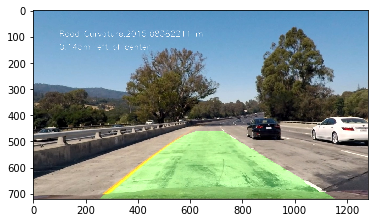

In [11]:
#image=mpimg.imread('examples/binary_combo_example.jpg')
#image = mpimg.imread('examples/warped_straight_lines.jpg')
#image = mpimg.imread('test_images/straight_lines2.jpg')
image = mpimg.imread('test_images/test1.jpg')
#image = mpimg.imread('camera_cal/calibration5.jpg')


result,mtx,dist=Cal_undistort(image, objpoints, imgpoints) # Funtion to calibrate camera and undistort the images.
output = combined_thresh(result)
top_down, perspective_M, src, dst= WarpPerspective(output, mtx, dist)
Minv = np.linalg.inv(perspective_M)

leftx,lefty,rightx,righty,out_img = search_around_poly(top_down)
left_fitx, right_fitx, ploty, center_dist= poly(top_down)
left,right = measure_curvature_real(out_img,leftx,lefty,rightx,righty)
curvature = (left+right)/2

warp_zero = np.zeros_like(top_down).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
FinalOutput = cv2.addWeighted(result, 1, newwarp, 0.3, 0)
    
#warp_zero = np.zeros_like(top_down).astype(np.uint8)


    
# src=tuple(map(tuple,src))
# dst=tuple(map(tuple,dst))

# cv2.line(result, src[0], src[1], [255, 0, 0], 8)
# cv2.line(result, src[1], src[2], [255, 0, 0], 8)
# cv2.line(result, src[2], src[3], [255, 0, 0], 8)
# cv2.line(result, src[0], src[3], [255, 0, 0], 8)

# cv2.line(top_down, dst[0], dst[1], [255, 0, 0], 8)
# cv2.line(top_down, dst[1], dst[2], [255, 0, 0], 8)
# cv2.line(top_down, dst[2], dst[3], [255, 0, 0], 8)
# cv2.line(top_down, dst[0], dst[3], [255, 0, 0], 8)

if center_dist > 0:
    direction = 'right'
else:
    direction = 'left' 
abs_center_dist = abs(center_dist)
text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
cv2.putText(FinalOutput, text, (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), lineType=cv2.LINE_AA)
cv2.putText(FinalOutput, 'Road Curvature:' +str(curvature) +' m', (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA) 
    
     

plt.imshow(FinalOutput)


mpimg.imsave('output_images/' +'PlottedBackTestImage6.jpg', FinalOutput)
#mpimg.imsave('test_images_output/' + image_name, lines_edges)


In [31]:
def process_image(image):
    
    result,mtx,dist=Cal_undistort(image, objpoints, imgpoints) # Funtion to calibrate camera and undistort the images.
    #output = ColorGradient(result) #Function used by combined color and gradient thresholds for lane detection.
    output = combined_thresh(result)
    top_down, perspective_M, src, dst= WarpPerspective(output, mtx, dist)
    Minv = np.linalg.inv(perspective_M)
    
    leftx,lefty,rightx,righty,out_img = search_around_poly(top_down)
    left_fitx, right_fitx, ploty, center_dist= poly(top_down)
    left,right = measure_curvature_real(out_img,leftx,lefty,rightx,righty)
    curvature = (left+right)/2
    
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    FinalOutput = cv2.addWeighted(result, 1, newwarp, 0.3, 0)
    
    if center_dist > 0:
        direction = 'right'
    else:
        direction = 'left' 
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(FinalOutput, text, (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), lineType=cv2.LINE_AA)
    cv2.putText(FinalOutput, 'Road Curvature:' +str(curvature) +' m', (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA) 
    
        
    
    return FinalOutput

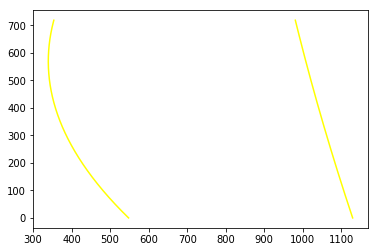

In [32]:
image = mpimg.imread('test_images/test1.jpg')
output = process_image(image)
#print(output)

[MoviePy] >>>> Building video test_videos_output/output_video.mp4
[MoviePy] Writing video test_videos_output/output_video.mp4


100%|█████████▉| 1260/1261 [17:10<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output_video.mp4 

CPU times: user 13min 4s, sys: 1min 48s, total: 14min 52s
Wall time: 17min 13s


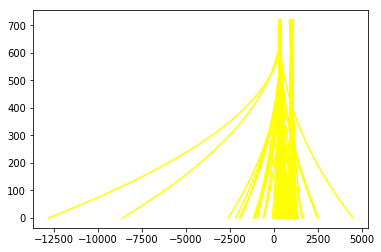

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

final_output = 'output_video.mp4' # the name of output file
clip1 = VideoFileClip("project_video.mp4") # You have to specify a folder of input file and input file name
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile('test_videos_output/' + final_output, audio=False)